In [6]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
df = pd.read_csv("../Data/강남 일별 시간대별 승객유형별 승하차인원 최종.csv")

In [8]:
df.head()

,datetime,연,월,일,시간,요일,주말,공휴일,외국인,우대권,일반
0,2022-06-01 05:00:00,2022,6,1,5,2,0,1,6.0,116.0,939.0
1,2022-06-01 06:00:00,2022,6,1,6,2,0,1,0.0,349.0,1085.0
2,2022-06-01 07:00:00,2022,6,1,7,2,0,1,0.0,232.0,1280.0
3,2022-06-01 08:00:00,2022,6,1,8,2,0,1,0.0,205.0,2402.0
4,2022-06-01 09:00:00,2022,6,1,9,2,0,1,1.0,249.0,3740.0


In [9]:
# 모델 입력 특징(Feature)과 출력(Target) 변수 설정
features = ['연', '월', '일', '시간', '요일', '주말', '공휴일']
targets = ['외국인', '우대권', '일반']

X = df[features]
y = df[targets]

In [10]:
from sklearn.model_selection import train_test_split

# 데이터를 학습/테스트로 분할 (80:20 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("학습 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)

학습 데이터 크기: (11696, 7)
테스트 데이터 크기: (2924, 7)


In [19]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# 결과 정리
results = {
    '모델': ['XGBoost', 'KNN'],
    'MSE': [mse_xgb, mse_knn],
    'R²': [r2_xgb, r2_knn]
}

results_df = pd.DataFrame(results)
print(results_df)

        모델            MSE        R²
0  XGBoost   82754.451129  0.906291
1      KNN  928897.478824  0.808646


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, y_train)

print("최적 파라미터:", grid_search.best_params_)
print("최고 R² 점수:", grid_search.best_score_)

최적 파라미터: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
최고 R² 점수: 0.9082946530858985


In [21]:
best_xgb_model = XGBRegressor(
    learning_rate=0.1,
    max_depth=8,
    n_estimators=100,
    random_state=42
)
best_xgb_model.fit(X_train, y_train)
y_pred_best_xgb = best_xgb_model.predict(X_test)

# 성능 평가
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f"최적화된 XGBoost - MSE: {mse_best_xgb}")
print(f"최적화된 XGBoost - R²: {r2_best_xgb}")

최적화된 XGBoost - MSE: 78043.10251188476
최적화된 XGBoost - R²: 0.906957507644944


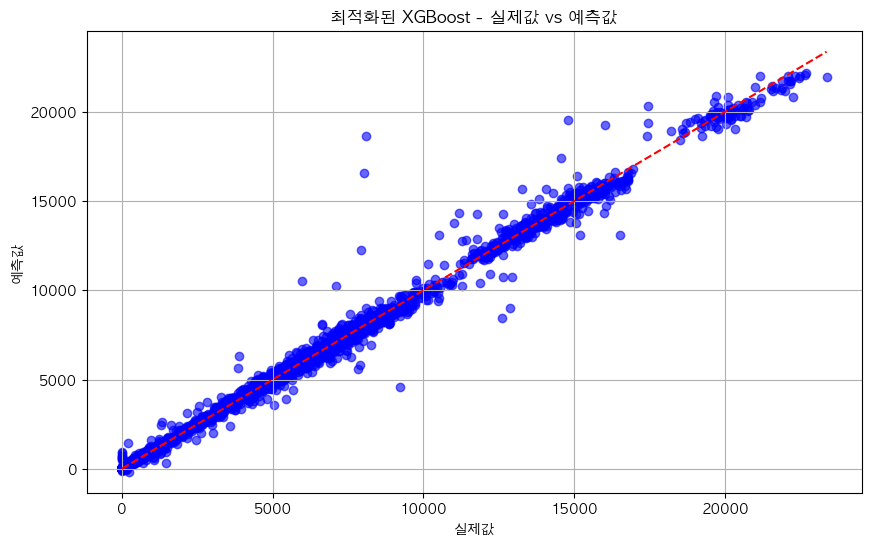

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("최적화된 XGBoost - 실제값 vs 예측값")
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.grid()
plt.show()

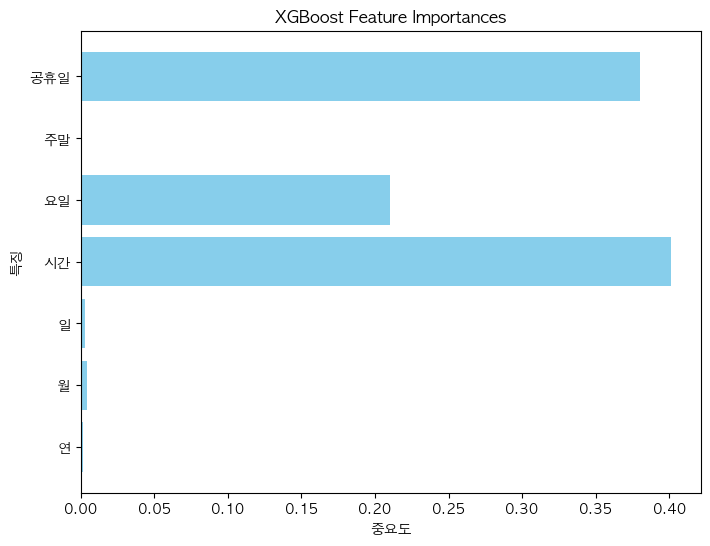

In [23]:
feature_importances = best_xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.title("XGBoost Feature Importances")
plt.xlabel("중요도")
plt.ylabel("특징")
plt.show()

In [24]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='r2')
print(f"교차 검증 R² 점수: {cv_scores}")
print(f"교차 검증 평균 R²: {cv_scores.mean()}")

교차 검증 R² 점수: [0.49792554 0.82795694 0.87353127 0.87579449 0.89255184]
교차 검증 평균 R²: 0.7935520160109579


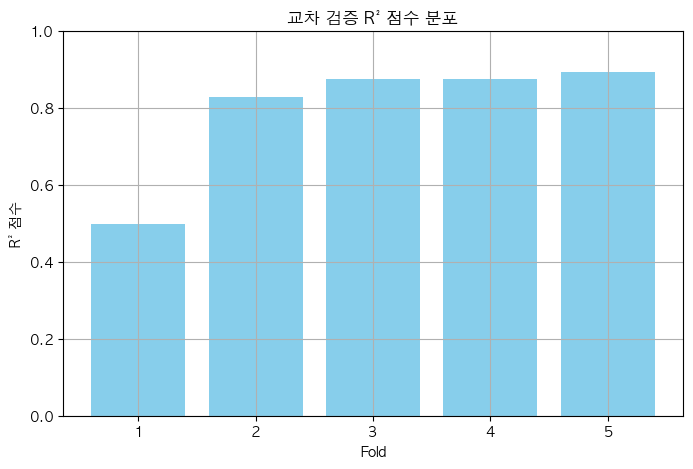

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
plt.title("교차 검증 R² 점수 분포")
plt.xlabel("Fold")
plt.ylabel("R² 점수")
plt.ylim(0, 1)
plt.grid()
plt.show()

In [31]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 모델 초기화
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=12, min_samples_split=5, random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

# 학습 데이터 점수
train_score = rf_model.score(X_train, y_train)
print(f"Train Score (R²): {train_score}")

# 테스트 데이터 점수
test_score = rf_model.score(X_test, y_test)
print(f"Test Score (R²): {test_score}")

# 교차 검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation Scores: {scores}")
print(f"Mean CV Score: {scores.mean()}")

Train Score (R²): 0.8676604386973267
Test Score (R²): 0.8474833969102428
Cross-Validation Scores: [0.00596679 0.79843111 0.84022086 0.82518692 0.8441219 ]
Mean CV Score: 0.662785515920872


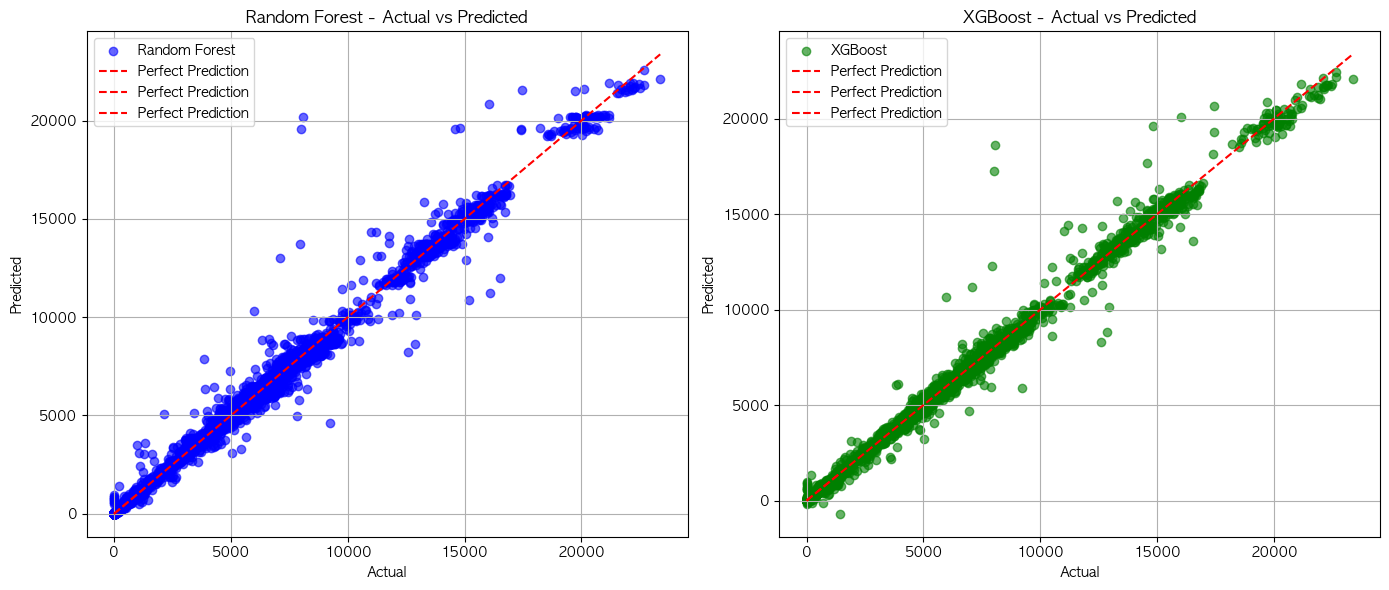

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Random Forest 예측값
y_pred_rf = rf_model.predict(X_test)

# XGBoost 예측값
y_pred_xgb = xgb_model.predict(X_test)

# 산점도 시각화
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Random Forest - Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='green', label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('XGBoost - Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

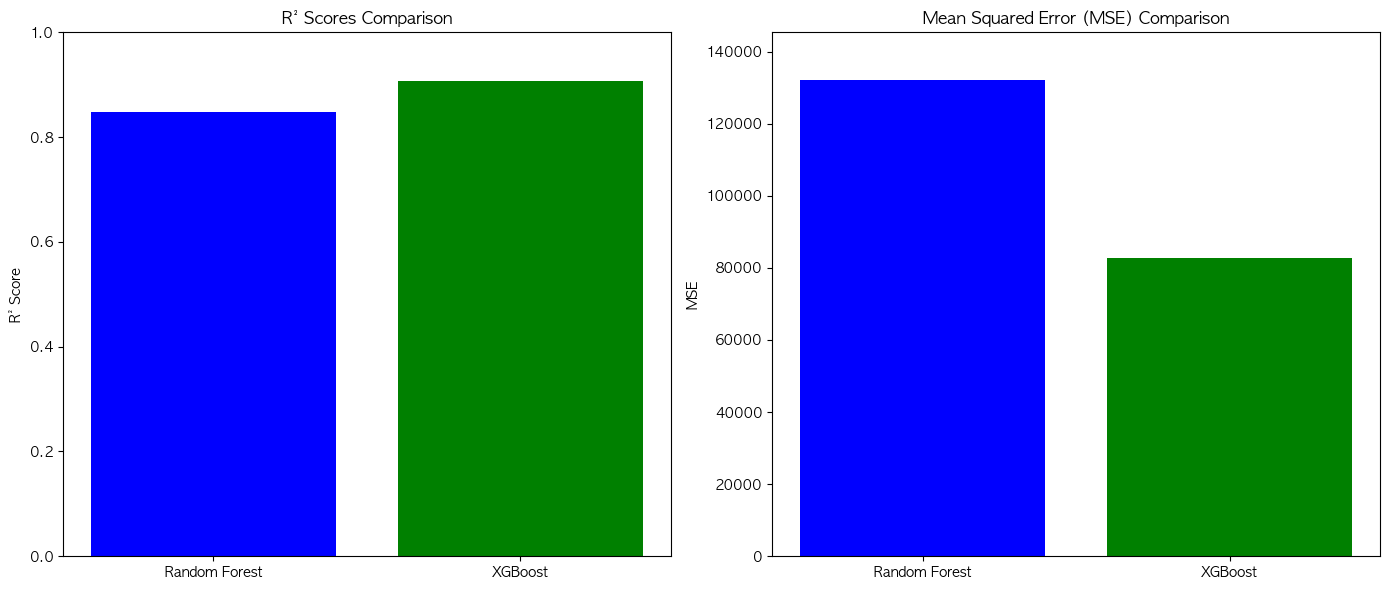

In [34]:
import matplotlib.pyplot as plt

# 모델별 R²와 MSE
r2_scores = [rf_model.score(X_test, y_test), xgb_model.score(X_test, y_test)]
mse_scores = [
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_xgb)
]

# R² 비교
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
models = ['Random Forest', 'XGBoost']
plt.bar(models, r2_scores, color=['blue', 'green'])
plt.title('R² Scores Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1)  # R² 점수 범위

# MSE 비교
plt.subplot(1, 2, 2)
plt.bar(models, mse_scores, color=['blue', 'green'])
plt.title('Mean Squared Error (MSE) Comparison')
plt.ylabel('MSE')
plt.ylim(0, max(mse_scores) * 1.1)  # MSE 범위

plt.tight_layout()
plt.show()

In [88]:
import numpy as np
import pandas as pd
import holidays
from datetime import datetime

# 한국 공휴일 정보
kr_holidays = holidays.KR()

# 특징 생성 함수
def create_features_for_datetime(dt):
    """datetime에서 특징을 생성"""
    return {
        'datetime': dt,
        '연': dt.year,
        '월': dt.month,
        '일': dt.day,
        '시간': dt.hour,
        '요일': dt.weekday(),
        '주말': 1 if dt.weekday() >= 5 else 0,
        '공휴일': 1 if dt in kr_holidays else 0,
    }

# 미래 예측 함수
def predict_passenger_count(model, future_datetime):
    """미래 승객 수 예측"""
    feature = create_features_for_datetime(future_datetime)
    feature_df = pd.DataFrame([feature])
    feature_columns = ['연', '월', '일', '시간', '요일', '주말', '공휴일']
    feature_input = feature_df[feature_columns]
    prediction = model.predict(feature_input)
    
    # 결과가 0보다 작으면 0으로 처리하고 소숫점 반올림
    prediction = np.clip(np.round(prediction), 0, None)  # 0보다 작은 값을 0으로, 소숫점 반올림
    
    if len(prediction) == 1:
        return prediction[0]
    return prediction

# 특정 날짜의 전체 시간대 예측 (1시~4시는 제외)
def predict_specific_date_all_hours(model, date_input):
    """
    특정 날짜의 0시부터 23시까지 모든 시간대의 승객 수 예측
    1시~4시는 제외
    """
    # date_input이 '20241220' 형식일 때, 이를 datetime 형식으로 변환
    specific_date = datetime.strptime(date_input, '%Y%m%d')
    
    predictions = []
    for hour in range(24):
        if 1 <= hour <= 4:  # 1시부터 4시는 제외
            continue
        current_time = specific_date.replace(hour=hour, minute=0, second=0, microsecond=0)
        predicted_count = predict_passenger_count(model, current_time)
        if isinstance(predicted_count, np.ndarray):  # 다수의 값일 경우
            predictions.append({
                'datetime': current_time.strftime('%Y-%m-%d %H:%M:%S'),
                '외국인': predicted_count[0],
                '우대권': predicted_count[1],
                '일반': predicted_count[2],
            })
        else:  # 단일 예측값
            predictions.append({
                'datetime': current_time.strftime('%Y-%m-%d %H:%M:%S'),
                '예측 승객 수': predicted_count
            })
    
    return pd.DataFrame(predictions)

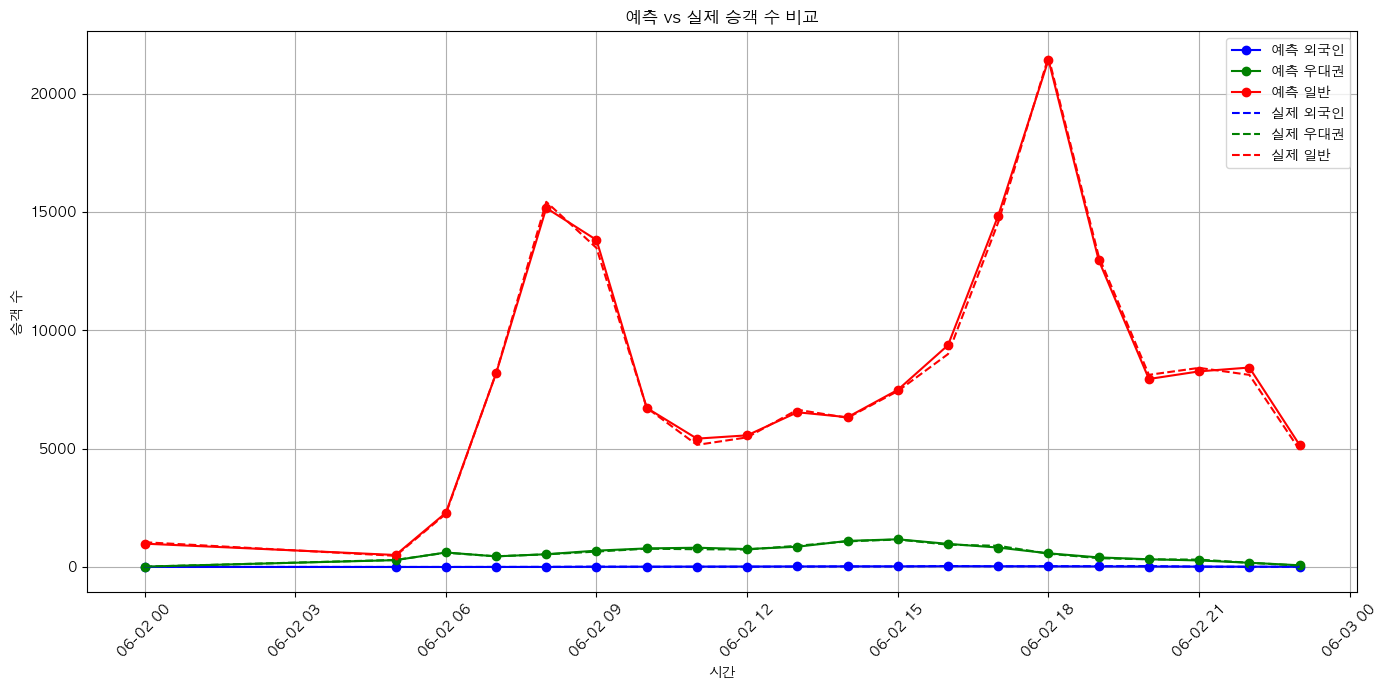

In [98]:
# 예측 실행
date_input = input("예측할 날짜를 입력하세요 (YYYYMMDD): ")
predictions_for_date = predict_specific_date_all_hours(best_xgb_model, date_input)

# 'datetime' 컬럼을 datetime 형식으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 입력 받은 날짜에 해당하는 데이터만 필터링
# 'date_input' 형식을 '%Y%m%d'로 변환하여 datetime 형식으로 필터링
specific_date = datetime.strptime(date_input, '%Y%m%d').date()
df_filtered = df[df['datetime'].dt.date == specific_date]

import matplotlib.pyplot as plt

# 'datetime' 컬럼을 datetime 형식으로 변환 (예측 결과)
predictions_for_date['datetime'] = pd.to_datetime(predictions_for_date['datetime'])

# df_filtered에서 'datetime'을 datetime 형식으로 변환 (실제 데이터)
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

# 1. 예측된 승객 수
plt.figure(figsize=(14, 7))
plt.plot(predictions_for_date['datetime'], predictions_for_date['외국인'], label='예측 외국인', color='blue', marker='o')
plt.plot(predictions_for_date['datetime'], predictions_for_date['우대권'], label='예측 우대권', color='green', marker='o')
plt.plot(predictions_for_date['datetime'], predictions_for_date['일반'], label='예측 일반', color='red', marker='o')

# 2. 실제 승객 수 (df_filtered에서 외국인, 우대권, 일반)
plt.plot(df_filtered['datetime'], df_filtered['외국인'], label='실제 외국인', color='blue', linestyle='dashed')
plt.plot(df_filtered['datetime'], df_filtered['우대권'], label='실제 우대권', color='green', linestyle='dashed')
plt.plot(df_filtered['datetime'], df_filtered['일반'], label='실제 일반', color='red', linestyle='dashed')

# 그래프 설정
plt.title('예측 vs 실제 승객 수 비교')
plt.xlabel('시간')
plt.ylabel('승객 수')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # x-axis 시간 라벨이 잘 보이도록 회전

# 차트 출력
plt.tight_layout()
plt.show()

In [106]:
# 예측 실행
date_input = input("예측할 날짜를 입력하세요 (YYYYMMDD): ")
predictions_for_date = predict_specific_date_all_hours(best_xgb_model, date_input)
predictions_for_date

,datetime,외국인,우대권,일반
0,2023-12-25 00:00:00,0.0,0.0,0.0
1,2023-12-25 05:00:00,0.0,89.0,372.0
2,2023-12-25 06:00:00,0.0,296.0,678.0
3,2023-12-25 07:00:00,0.0,170.0,730.0
4,2023-12-25 08:00:00,3.0,150.0,1348.0
5,2023-12-25 09:00:00,5.0,234.0,2173.0
6,2023-12-25 10:00:00,10.0,301.0,2679.0
7,2023-12-25 11:00:00,15.0,327.0,3357.0
8,2023-12-25 12:00:00,19.0,327.0,4353.0
9,2023-12-25 13:00:00,22.0,352.0,4822.0
